**1a)**
Implement a function that computes the binary entropy

The function takes as input one feature vector x and the corresponding label y. Binary entropy means binary labels y=0/1

**1b)**
Implement a function that takes one given feature of a dataset, and finds the best split (the split that
minimises the entropy) for the data. It is common to iterate over the data feature values, and calculate
the entropy for the subsets that are larger or smaller (or equal) than the current value in the iteration.
return the split that minimises the entropy and the corresponding entropy for the split

**1c)**
Implement a function that takes a dataset (nsamples × nfeatures) and finds the single best split (the split
with the least entropy) across all features. That is the function find_best_split. Return the best split
found.

**1d)**
Using the functions you implemented above, write your own version of the Classification Tree algorithm,
using recursion. Remember to include a parameter specifying the maximum depth of the tree to prevent
overfitting
![Ethem univariate tree construction](img/decision_tree.png)

In [61]:
MINIMUM_ENTROPY = 0.01
MAXIMUM_DEPTH = 50

import numpy as np
from numpy import log2
import pandas as pd
import matplotlib.pyplot as plt
import sys

def entropy(y: np.array):
    counts = np.bincount(y)
    p_0 = counts[0] / len(y)
    p_1 = 1 - p_0
    log2p0 = 0 if p_0 == 0 else log2(p_0)
    log2p1 = 0 if p_1 == 0 else log2(p_1)
    return -p_0 * log2p0 - p_1 * log2p1


def split_feature(x: np.array, y: np.array):
    min_impurity_index = None
    min_impurity = sys.float_info.max
    # Iterate over all values in the features in x.
    i_sorted = np.argsort(x)
    x = x[i_sorted]  
    y = y[i_sorted]
        
    for i in range(len(x)-1):
        sub_1 = y[:i+1]
        sub_2 = y[i+1:]
        e_1 = entropy(sub_1)
        e_2 = entropy(sub_2)
        impurity = e_1 * len(sub_1) / len(x) + e_2 * len(sub_2) / len(x)
        if impurity < min_impurity:
            min_impurity = impurity
            min_impurity_index = i
    split_value = x[min_impurity_index] if min_impurity_index == len(x)-1 else (x[min_impurity_index+1] + x[min_impurity_index])/2 

    return split_value, min_impurity

def find_best_split(X: np.array, y: np.array):
    M = X.shape[1]
    min_impurity_global = sys.float_info.max
    min_impurity_feature_index = None
    split_value = None
    for i in range(M):
        feature = X[:, i]
        value, min_impurity = split_feature(feature, y)
        if min_impurity < min_impurity_global:
            min_impurity_global = min_impurity
            min_impurity_feature_index = i
            split_value = value
            # There might be a break here if we got a entropy near 0.
            if min_impurity_global < 1e-20:
                split_value = None
                break

    return min_impurity_feature_index, split_value


class Tree:
    # Initialize variables
    def __init__(self, level, left):
        self.__split_value = None
        self.__feature_index = None
        self.__left_child = None
        self.__right_child = None
        self.__value = None
        self.__level = level + 1
        if left is None:
            self.__direction = "Root"
        else:
            self.__direction = "Left" if left else "Right"

    # Implements the "GenerateTree"-function from Fig. 9.3 in the book.
    def fit(self, data, labels):

        if entropy(labels) < MINIMUM_ENTROPY:  # Stopping condition for recursion
            # Pick the label that has the majority. To be used if we are a leaf-node
            self.__value = 1 if np.mean(labels) > 0.5 else 0
            print(self.__direction,"leaf node at level",self.__level, "with value", self.__value)
            return
        
        if self.__level >= MAXIMUM_DEPTH:
            self.__value = 1 if np.mean(labels) > 0.5 else 0
            print("Max depth reached, bailing out")
            return

        feature_index, split_value = find_best_split(data, labels)
        if split_value is None:
            self.__value = 1 if np.mean(labels) > 0.5 else 0
            print("0 in impurity, this should be a leaf!")
            return

        self.__feature_index = feature_index
        self.__split_value = split_value
        print(self.__direction,"node at level", self.__level, ". Feature index:", feature_index, ", split value",split_value)

        feature = data[:, feature_index]
        indexes_left = np.where(feature <= split_value)[0]
        indexes_right = np.where(feature > split_value)[0]
        # if len(indexes_right) == 0 :
        #     print("Data:",data)
        #     print("Labels", labels)
            
        # print("Right indexes:", indexes_right)
        # print("Left indexes:", indexes_left)

        # Create branches
        self.__left_child = Tree(self.__level, True)
        self.__right_child = Tree(self.__level, False)

        # Generate sub-trees.
        left_data = data[indexes_left, :]
        if len(left_data) > 0:
            self.__left_child.fit(left_data, labels[indexes_left])
        else:
            self.__left_child = None
            print("Should not happen, left_data is empty")
            
        right_data = data[indexes_right, :]
        if len(right_data) > 0:
            self.__right_child.fit(right_data, labels[indexes_right])
        else:
            self.__right_child = None
            print("Should not happen, right_data is empty")

    # Find leaf corresponding to row
    def __predict(self, x):
        if self.__left_child is None and self.__right_child is None:  # We are a leaf-node
            return self.__value

        feature_val = x[self.__feature_index]
        if feature_val <= self.__split_value:
            return self.__left_child.__predict(x)
        else:
            return self.__right_child.__predict(x)
        
    def predict(self, X):
        N = X.shape[0]
        y = np.empty([N,1])
        for i in range(N):
            y[i] = self.__predict(X[i, :])
        return y

data = pd.read_csv("data/tictac-end.csv", skiprows=7, delimiter=" ")


y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

random_indexes = np.random.permutation(y.shape[0])
y = y[random_indexes]
X = X[random_indexes]
y = y[:150]
X = X[:150,:]
print(random_indexes[:3])

indexes = [752, 276, 404]
# y = y[indexes]
# X = X[indexes]

print(y)
print(X)

decision_tree = Tree(0,None)
decision_tree.fit(X, y)


[ 29 763 718]
[1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0
 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1
 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0
 0 0]
[[ 1  1  1 ... -1  0  1]
 [-1  1  1 ... -1  1  1]
 [ 1  0 -1 ... -1  1 -1]
 ...
 [ 1 -1  1 ... -1  1 -1]
 [ 1 -1  0 ... -1 -1  1]
 [ 1 -1  0 ...  1 -1  1]]
Root node at level 1 . Feature index: 4 , split value 1.0
Left node at level 2 . Feature index: 4 , split value 1.0
Left node at level 3 . Feature index: 4 , split value 1.0
Left node at level 4 . Feature index: 4 , split value 1.0
Left node at level 5 . Feature index: 4 , split value 1.0
Left node at level 6 . Feature index: 4 , split value 1.0
Left node at level 7 . Feature index: 4 , split value 1.0
Left node at level 8 . Feature index: 4 , split value 1.0
Left node at level 9 . Feature index: 4 , split value 1.0
Le

**1e)**
Test your implementation on the datasets in blobs.csv and flame.csv. Plot the data, and the regions
found by the tree.

First, test with blobs.csv


Root node at level 1 . Feature index: 0 , split value 0.5044
Left node at level 2 . Feature index: 1 , split value 0.4238
Left leaf node at level 3 with value 0
Right node at level 3 . Feature index: 1 , split value 0.7033499999999999
Left node at level 4 . Feature index: 0 , split value 0.4291
Left leaf node at level 5 with value 0
Right node at level 5 . Feature index: 0 , split value 0.4301
Left leaf node at level 6 with value 0
Right leaf node at level 6 with value 1
Right node at level 4 . Feature index: 0 , split value -0.0628
Left leaf node at level 5 with value 0
Right leaf node at level 5 with value 1
Right node at level 2 . Feature index: 1 , split value 0.21565
Left node at level 3 . Feature index: 0 , split value 0.56515
Left leaf node at level 4 with value 0
Right node at level 4 . Feature index: 0 , split value 0.5835
Left leaf node at level 5 with value 0
Right leaf node at level 5 with value 1
Right node at level 3 . Feature index: 0 , split value 0.5107
Left leaf node 

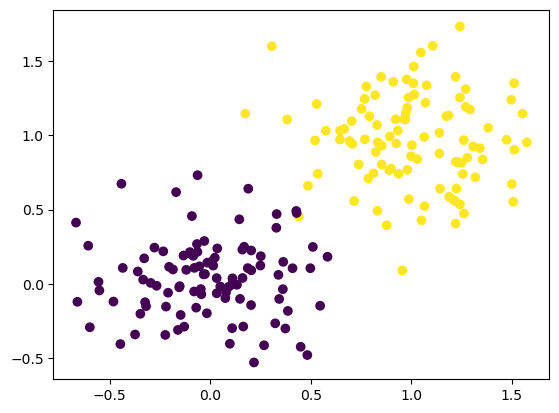

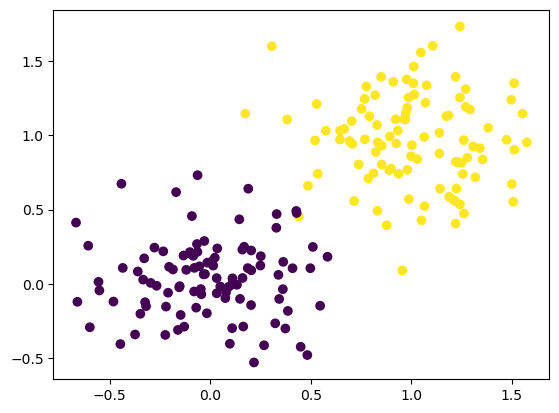

In [31]:
data = pd.read_csv("data/blobs.csv", skiprows=1, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

decision_tree = Tree(0,None)
decision_tree.fit(X, y)

# Plot the ground truth
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Now run predict on the whole training set and plot it similarly
y_pred = decision_tree.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)


Now, test on flame.csv

Root node at level 1 . Feature index: 1 , split value 20.45
Left leaf node at level 2 with value 1
Right node at level 2 . Feature index: 0 , split value 10.45
Left node at level 3 . Feature index: 0 , split value 2.725
Left node at level 4 . Feature index: 1 , split value 23.15
Left leaf node at level 5 with value 1
Right node at level 5 . Feature index: 0 , split value 1.35
Left leaf node at level 6 with value 0
Right leaf node at level 6 with value 1
Right node at level 4 . Feature index: 1 , split value 21.35
Left node at level 5 . Feature index: 0 , split value 5.2
Left leaf node at level 6 with value 1
Right leaf node at level 6 with value 0
Right node at level 5 . Feature index: 0 , split value 2.95
Left leaf node at level 6 with value 1
Right leaf node at level 6 with value 0
Right node at level 3 . Feature index: 0 , split value 10.55
Left leaf node at level 4 with value 0
Right leaf node at level 4 with value 1


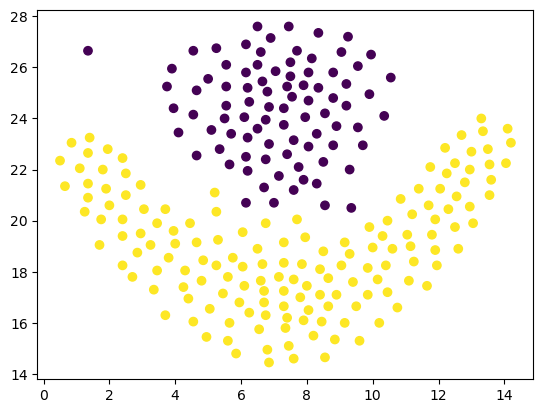

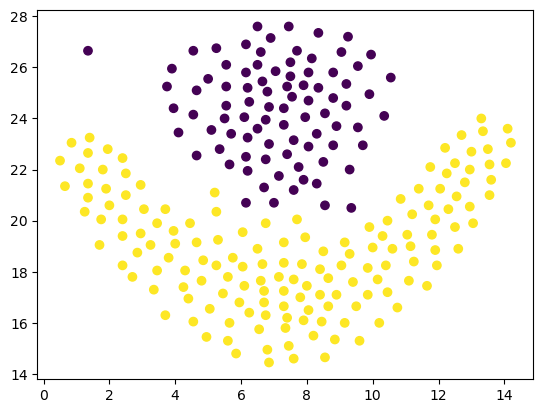

In [32]:
data = pd.read_csv("data/flame.csv", skiprows=5, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

decision_tree = Tree(0,None)
decision_tree.fit(X, y)

# Plot the ground truth
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Now run predict on the whole training set and plot it similarly
y_pred = decision_tree.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)



**1f)** Vizualise tree 
https://levelup.gitconnected.com/binary-tree-implementation-and-visualization-in-python-2f4782887ca2

**1g)** Test on tictac.csv
Split the data into training- and test-sets. Train your classification tree using the training set, and test it
using the testing set. How is the generalization performance?

In [6]:
data = pd.read_csv("data/tictac-end.csv", skiprows=7, delimiter=" ")

y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

decision_tree = Tree(0,None)
decision_tree.fit(X, y)

# Plot the ground truth
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Now run predict on the whole training set and plot it similarly
y_pred = decision_tree.predict(X)
plt.scatter(X[:,0], X[:,1], c=y_pred)



Root node at level 1 . Feature index: 4 , split value 1
Left node at level 2 . Feature index: 4 , split value 1
Left node at level 3 . Feature index: 4 , split value 1
Left node at level 4 . Feature index: 4 , split value 1
Left node at level 5 . Feature index: 4 , split value 1
Left node at level 6 . Feature index: 4 , split value 1
Left node at level 7 . Feature index: 4 , split value 1
Left node at level 8 . Feature index: 4 , split value 1
Left node at level 9 . Feature index: 4 , split value 1
Left node at level 10 . Feature index: 4 , split value 1
Left node at level 11 . Feature index: 4 , split value 1
Left node at level 12 . Feature index: 4 , split value 1
Left node at level 13 . Feature index: 4 , split value 1
Left node at level 14 . Feature index: 4 , split value 1
Left node at level 15 . Feature index: 4 , split value 1
Left node at level 16 . Feature index: 4 , split value 1
Left node at level 17 . Feature index: 4 , split value 1
Left node at level 18 . Feature index: 4

KeyboardInterrupt: 